# Predicting PM2.5 concentrations via rolling forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from pm25_hyperparameters import *

data=pd.read_csv("BeijingPM_dataset.csv")
picker=data["date"]
picker_test=picker[(picker>="2014-03-01 00:00:00") & (picker<"2014-04-01 00:00:00")]
test_idx=list(picker_test.index)
data.drop("date",axis=1,inplace=True)
data.head()

,year,month,day,hour,season,PM,DEWP,HUMI,PRES,TEMP,...,precipitation_max,Iws_max,PM_max,TEMP_min,DEWP_min,HUMI_min,PRES_min,precipitation_min,Iws_min,PM_min
0,2010,1,3,0,4,63.0,-7.0,92.0,1027.0,-6.0,...,0.4,58.56,181.0,-14.0,-21.0,25.0,1014.0,0.0,0.89,63.0
1,2010,1,3,1,4,65.0,-8.0,85.0,1026.0,-6.0,...,0.5,61.69,181.0,-14.0,-21.0,25.0,1014.0,0.0,0.89,63.0
2,2010,1,3,2,4,55.0,-8.0,92.0,1026.0,-7.0,...,0.5,65.71,181.0,-14.0,-21.0,25.0,1014.0,0.0,0.89,55.0
3,2010,1,3,3,4,65.0,-8.0,92.0,1025.0,-7.0,...,0.7,68.84,181.0,-12.0,-20.0,25.0,1014.0,0.0,0.89,55.0
4,2010,1,3,4,4,83.0,-8.0,92.0,1024.0,-7.0,...,1.2,72.86,181.0,-10.0,-20.0,25.0,1014.0,0.0,0.89,55.0


## Parameters and functions used for model training and testing

In [14]:
x_met=["year","month","day","hour","season"]
y_met=list(set(prim_fea)-set(["PM"]))

datetime_cols=["is_holiday","is_special_event"]

x_pm=list(set(data.columns)-set(["PM"])-set(datetime_cols))

def fill_fea(df,p,cols):
    pos=p-test_idx[0]
    for col in cols:
        lagtmp=[]
        for t in range(1,lag_hours+1):
            if t<=pos:
                x=df.loc[pos-t,col]
            else:
                x=data.loc[test_idx[0]+pos-t,col]
            df.loc[pos,"%s_lag%d" % (col,t)]=x
            lagtmp.append(x)
        df.loc[pos,"%s_mean" % col]=np.mean(lagtmp)
        df.loc[pos,"%s_min" % col]=np.min(lagtmp)
        df.loc[pos,"%s_max" % col]=np.max(lagtmp)

# Column names for lagged features
for col in y_met:
    for t in range(1,lag_hours+1):
        x_met.append("%s_lag%d" % (col,t))
    for r in ["mean","max","min"]:
        x_met.append("%s_%s" % (col,r))
        
# Parameters for cross_validation
lgb_grid={
    "objective":["l1","l2","l2_root","mape"],
    "max_depth":[15, 20, 25, 30, 35],
    "num_leaves":[64,128,256],
    "min_data_in_leaf": [10,20,30],
    "learning_rate": [0.05,0.1,0.2,0.5],
    "feature_fraction": [0.5,0.7,1.0],
    "bagging_fraction": [0.5,0.7,1.0],
    "bagging_freq": [0,25,50]
}

## Find the best parameters for the PM2.5 prediction model

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import d

## Prepare the testing set for PM2.5 prediction

In [3]:
from sklearn.multioutput import MultiOutputRegressor


pm_test_file="BeijingPM_test.csv"
lowbs=list(range(test_idx[0],test_idx[-1],24))

if os.path.exists(pm_test_file):
    print("Reading the testing set from %s" % pm_test_file)
    pm_testset=pd.read_csv(pm_test_file)
    pm_testset.index=np.array(pm_testset["Unnamed: 0"],dtype=np.int)
    pm_testset.drop("Unnamed: 0",axis=1,inplace=True)
else:
    pm_testset=data.loc[test_idx].copy()
    print("Creating testing set for [%d:%d]" % (test_idx[0],test_idx[-1]+1))
    for i,lowb in enumerate(lowbs):
        met_train=data[:lowb]
        met_model=MultiOutputRegressor(LGBMRegressor(random_state=101,objective="rmse",eval_metric="rmse"),n_jobs=4)
        met_model.fit(met_train[x_met],met_train[y_met])
        for k in tqdm(range(lowb,lowb+24),desc="[%d:%d] (%d/%d)" % (lowb,lowb+24,i+1,len(lowbs))):
            fill_fea(pm_testset,k,y_met)
            pm_testset.loc[k,y_met]=pd.DataFrame(met_model.predict(pm_testset.loc[[k],x_met]),columns=y_met).loc[0]
    pm_testset.to_csv(pm_test_file)


Reading the testing set from BeijingPM_test.csv


## Predict PM2.5

In [4]:
pm_predict_file="BeijingPM_prediction.csv"

pm_df_list=[]

if os.path.exists(pm_predict_file):
    print("Reading existing PM2.5 prediction from %s" % pm_predict_file)
    pm_df=pd.read_csv(pm_predict_file)
else:
    print("Predicting PM2.5 for [%d:%d]" % (test_idx[0],test_idx[-1]))
    for i,lowb in enumerate(lowbs):
        pm_train=data[:lowb]
        pm_test=pm_testset[lowb:lowb+24]
        pm_control=LGBMRegressor(random_state=101,**pm_model_params)
        pm_control.fit(pm_train[x_pm],pm_train["PM"])
        pm_datetime=LGBMRegressor(random_state=101,**pm_model_params)
        pm_datetime.fit(pm_train[x_pm+datetime_cols],pm_train["PM"])
        pm_predict_control=[]
        pm_predict_datetime=[]
        for k in tqdm(range(lowb,lowb+24),desc="[%d:%d] (%d/%d)" % (lowb,lowb+24,i+1,len(lowbs))):
            fill_fea(pm_testset,k,["PM"])
            pm_predict_control.append(pm_control.predict(pm_testset.loc[[k],x_pm])[0])
            pm_predict_datetime.append(pm_datetime.predict(pm_testset.loc[[k],x_pm+datetime_cols])[0])

        pm_df_list.append(pd.DataFrame(
            {"LightGBM":pm_predict_control,"LightGBM + holidays and special events":pm_predict_datetime}))
        pm_df=pd.concat(pm_df_list)
        pm_df.to_csv(pm_predict_file,index=False)

pm_df.index=test_idx

Reading existing PM2.5 prediction from BeijingPM_prediction.csv


## Model Evaluation

After predicting PM2.5 concentration, we now begin analyzing the performance. In our study, we use three evaluation metrics to rank our model (let $y_i$ be the true value and $p_i$ be the predicted values).

$$MAE=\frac1N\sum_{i=1}^N|y_i-p_i|\quad RMSE=\sqrt{\frac1N\sum_{i=1}^N(y_i-p_i)^2}\quad SMAPE=\frac1N\sum_{i=1}^N\frac{|y_i-p_i|}{(|y_i|+|p_i|)/2}$$

In [5]:
# Combine true values and predicted values for comparison
pm_comp=pd.concat([data.loc[pm_df.index,"PM"],pm_df],axis=1)
pm_comp.index=picker[test_idx]

def get_mae(y,p):
    return abs(y-p).mean()

def get_rmse(y,p):
    return np.sqrt(np.square(y-p).mean())

def get_smape(y,p):
    return 1/len(y)*np.sum(2*abs(y-p)/(abs(y)+abs(p)+1e-7))

eval_metrics={"MAE":get_mae,"RMSE":get_rmse,"SMAPE":get_smape}

def pm_metrics(col,m):
    return eval_metrics[m](pm_comp["PM"],pm_comp[col])

pm_metrics={}

for m in eval_metrics.keys():
    pm_metrics[m]=[]

for col in pm_df.columns:
    for m in pm_metrics.keys():
        pm_metrics[m].append(eval_metrics[m](pm_comp["PM"],pm_comp[col]))

edf=pd.DataFrame(pm_metrics,index=pm_df.columns)
edf

,MAE,RMSE,SMAPE
LightGBM,12.783045,20.767158,0.167782
LightGBM + holidays and special events,12.874601,20.701031,0.172277


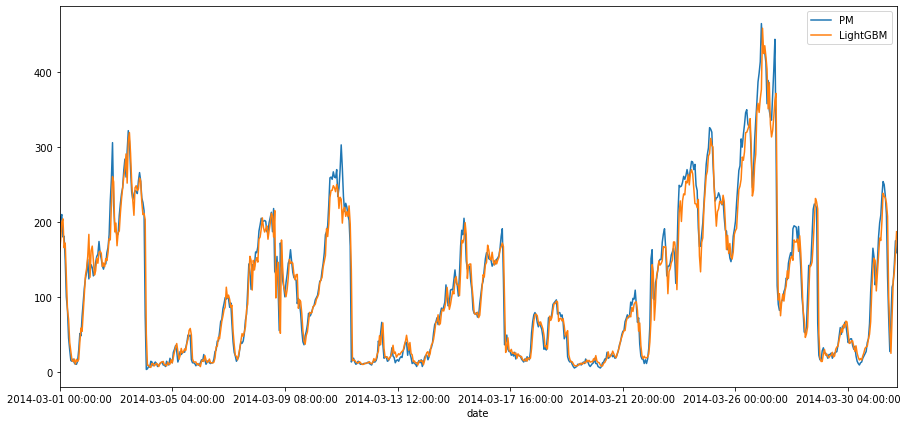

In [6]:
plt.figure(figsize=(15,7))
ax=plt.gca()
pm_comp[["PM","LightGBM"]].plot(ax=ax)

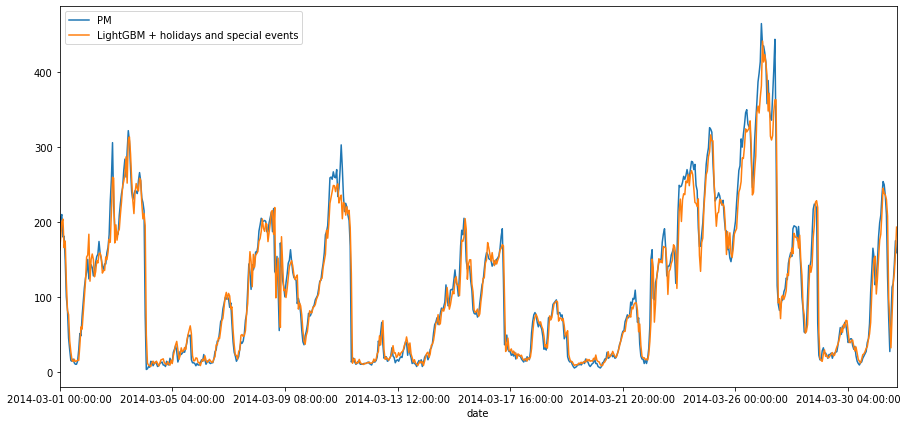

In [7]:
plt.figure(figsize=(15,7))
ax=plt.gca()
pm_comp[["PM","LightGBM + holidays and special events"]].plot(ax=ax)

## Model performance during special events

As shown below, three events fall within the span of the testing set.

In [8]:
events_df=pd.read_csv("Beijing_events.csv")
test_events=events_df[
    (events_df["date1"]<list(picker_test)[-1]) & (events_df["date0"]>=list(picker_test)[0])]
test_events

,date0,date1,type
13,2014-03-03,2014-03-04,visit
14,2014-03-05,2014-03-20,meeting
15,2014-03-20,2014-03-26,visit


Plot model prediction of each event

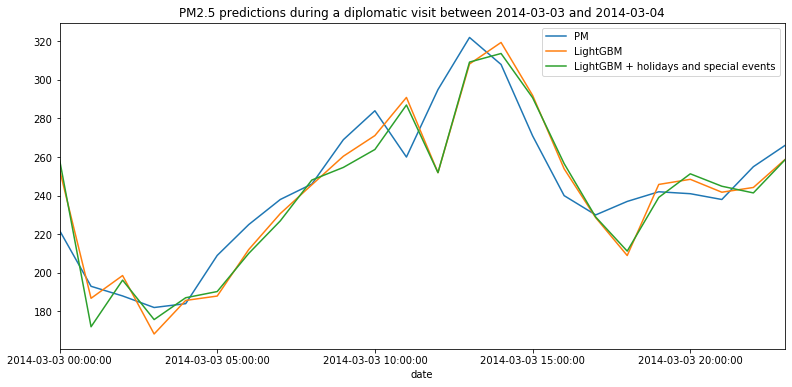

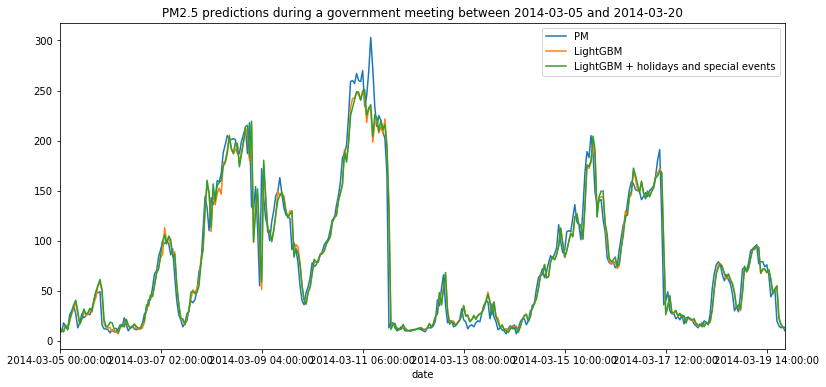

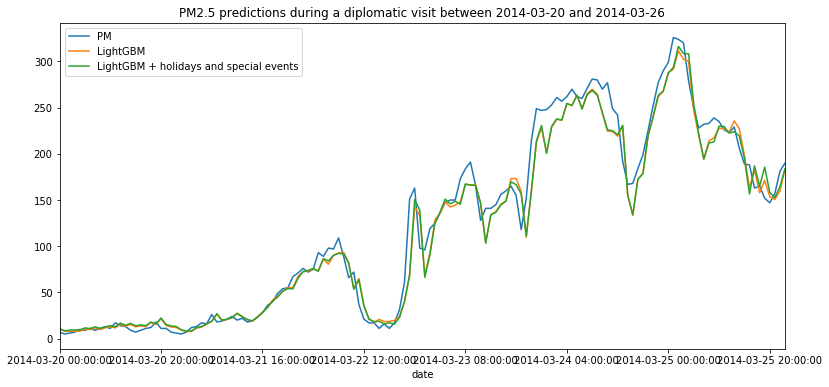

In [13]:
evt_map={
    "visit":"diplomatic visit",
    "meeting":"government meeting"
}

score_list=[]
score_dict={}

for d0,d1,t in zip(test_events["date0"],test_events["date1"],test_events["type"]):
    plt.figure(figsize=(13,6))
    rg=pm_comp.loc[d0:d1]
    ax=rg.plot(ax=plt.gca())
    ax.set_title("PM2.5 predictions during a %s between %s and %s" % (evt_map[t],d0,d1))
    score_dict={}
    for m in eval_metrics.keys():
        score_dict[m]=[]
    for col in pm_df.columns:
        for m in score_dict.keys():
            score_dict[m].append(eval_metrics[m](rg["PM"],rg[col]))

    score_list.append(pd.DataFrame(score_dict,index=pm_df.columns))

Evaluation scores of each special event interval

In [10]:
score_list

[                                              MAE       RMSE     SMAPE
 LightGBM                                13.476923  17.134008  0.055398
 LightGBM + holidays and special events  14.561742  17.951035  0.060273,
                                               MAE       RMSE     SMAPE
 LightGBM                                 9.992999  16.945117  0.166079
 LightGBM + holidays and special events  10.202199  16.904195  0.173865,
                                               MAE       RMSE     SMAPE
 LightGBM                                12.313436  18.029515  0.162878
 LightGBM + holidays and special events  12.234047  18.170482  0.165355]